In [ ]:
import os
import random
import numpy as np
from scipy.io import wavfile

# Function to add lag (in seconds) and reduce power
def process_signal(signal, sample_rate, lag_seconds=0.05, power_reduction_db=-20):
    power_reduction = 10 ** (power_reduction_db / 20)
    processed_signal = signal * power_reduction
    lag_samples = int(lag_seconds * sample_rate)
    processed_signal = np.pad(processed_signal, (lag_samples, 0), mode='constant')
    return processed_signal

# Function to mix multiple signals
def mix_signals(signals):
    max_length = max([len(signal) for signal in signals])
    mixed_signal = np.zeros(max_length)
    for signal in signals:
        padded_signal = np.pad(signal, (0, max_length - len(signal)), mode='constant')
        mixed_signal += padded_signal
    return mixed_signal

# Function to load .wav files
def load_wav(file_path):
    sample_rate, data = wavfile.read(file_path)
    return sample_rate, data

def save_wav(file_path, sample_rate, data):
    wavfile.write(file_path, sample_rate, data.astype(np.int16))

# Function to load multiple .wav files from a folder
def load_wav_files_from_folder(folder_path, limit=None):
    wav_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.wav')]
    loaded_signals = []
    for file in wav_files[:limit]:
        sample_rate, data = load_wav(file)
        loaded_signals.append(data)
    return sample_rate, loaded_signals

# Function to simulate the test signal by adding lag, reducing power, and mixing multiple additional speeches
def simulate_test_signal(folder_path, output_path, main_path, lag_seconds=0.05, power_reduction_db=-6, n_amp = 1):
    # List all .wav files in the folder
    wav_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.wav')]

    #sample_rate, test_noise = load_wav(tnoise_path)
    #sample_rate, error_noise = load_wav(enoise_path)

    # Randomly select a file as the test signal
    test_signal_file = random.choice(wav_files)
    remaining_files = [file for file in wav_files if file != test_signal_file]

    # Load primary test signal (to be filtered)
    sample_rate, test_signal = load_wav(test_signal_file)
    print(f"Test Signal: {test_signal_file}")

    # Load additional speech signals from the remaining files
    sample_rate, additional_speeches = load_wav_files_from_folder(folder_path, limit=20)

    # Add lag and reduce power for the test signal
    processed_test_signal = process_signal(test_signal, sample_rate, lag_seconds, power_reduction_db)

    # Mix all the additional speech signals
    additional_speech_mixed = mix_signals(additional_speeches)

    length = len(test_signal)

    test_noise = 2 * n_amp * (np.random.random(length) - 0.5)
    error_noise = 2 * n_amp * (np.random.random(length) - 0.5)

    # Mix the processed test signal with the additional speech noise
    final_signal = mix_signals([processed_test_signal, additional_speech_mixed, error_noise])
    test_signal1 = mix_signals([test_signal, test_noise, additional_speech_mixed])

    # Save the mixed signal as a .wav file
    save_wav(output_path, sample_rate, final_signal)
    save_wav(main_path, sample_rate, test_signal1)
    save_wav(original_path, sample_rate, test_signal)
    print(f"Processed and mixed signal saved to {output_path}")

# Relative paths to the folder and output file
folder_path = './sample_data/original'
#tnoise_path = './sample_data/modified/test_noise.wav'
#enoise_path = './sample_data/modified/error_noise.wav'
output_path = './sample_data/modified/error_signal.wav'
main_path = './sample_data/modified/main_signal.wav'
original_path = './sample_data/modified/orig_signal.wav'

# Simulate the test signal
simulate_test_signal(folder_path, output_path, main_path, lag_seconds=0.05, power_reduction_db=-6, n_amp = 1)

Test Signal: ./sample_data/original\OSR_us_000_0038_8k.wav
Processed and mixed signal saved to ./sample_data/modified/error_signal.wav


In [53]:
import numpy as np
#import pyaudio
from sklearn.ensemble import RandomForestClassifier
from scipy.signal import butter, lfilter
from scipy.io import wavfile

# Placeholder: Train a simple noise classifier
def train_noise_classifier():
    # Example: Train with features and labels
    features = np.random.rand(100, 2)  # Replace with real features
    labels = np.random.choice([0, 1, 2], 100)  # 0: Speech, 1: Traffic, 2: Wind noise
    classifier = RandomForestClassifier()
    classifier.fit(features, labels)
    return classifier

# Function to classify the noise type
def classify_noise(signal, classifier):
    # Extract features (for simplicity, mean and variance as example features)
    feature = np.array([np.mean(signal), np.var(signal)]).reshape(1, -1)
    return classifier.predict(feature)

# Filter functions
def butter_bandstop(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='bandstop')
    return b, a

def apply_filter(signal, filter_type, fs):
    if filter_type == 'bandstop':
        b, a = butter_bandstop(200, 1000, fs)
        return lfilter(b, a, signal)
    return signal  # No filtering for unrecognized types

# Function to override ML decision with hardware input
def hardware_override(input_signal, hardware_input):
    if hardware_input == 1:  # Override with user input (e.g., hardware command)
        return 'bandstop'  # Force bandstop filter
    return None  # No override

# Main processing function
def process_audio(input_wav, output_wav, classifier, hardware_input):
    fs, signal = wavfile.read(input_wav)

    # Classify noise using ML model
    noise_type = classify_noise(signal, classifier)

    # Hardware input override
    filter_decision = hardware_override(signal, hardware_input)


    # If no override, use ML classification to select filter
    if filter_decision is None:
        if noise_type == 0:  # Speech
            filter_decision = 'bandstop'
        elif noise_type == 1:  # Traffic

            filter_decision = 'lowpass'
        elif noise_type == 2:  # Wind
            filter_decision = 'highpass'

    # Apply the chosen filter
    filtered_signal = apply_filter(signal, filter_decision, fs)

    # Save the filtered signal
    wavfile.write(output_wav, fs, filtered_signal.astype(np.int16))

# Train the classifier
classifier = train_noise_classifier()

# Example usage: Process an audio file with hardware input overriding ML
hardware_input = 1  # This could be a real-time signal from a hardware sensor
process_audio('input_noise.wav', 'output_filtered.wav', classifier, hardware_input)

AttributeError: partially initialized module 'pandas' has no attribute '_pandas_datetime_CAPI' (most likely due to a circular import)

In [32]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import lfilter

# Constants
NUM_HARMONICS = 40  # Number of harmonics to decompose
STEP_SIZE = 0.005  # FXNLMS step size
WINDOW_SIZE = 960  # Window size for F0 estimation (20ms window)

# Function to read .wav file
def read_wav(file_path):
    sample_rate, data = wavfile.read(file_path)
    return sample_rate, data.astype(np.float32)

# Function to save .wav file
def save_wav(file_path, sample_rate, data):
    wavfile.write(file_path, sample_rate, data.astype(np.int16))

def autocorrelation(signal, sample_rate):
    """Estimate fundamental frequency using autocorrelation method."""
    corr = np.correlate(signal, signal, mode='full')
    corr = corr[len(corr)//2:]  # Use positive lags
    d = np.diff(corr)
    start = np.where(d > 0)[0][0]  # First positive difference
    peak = np.argmax(corr[start:]) + start
    f0 = sample_rate / peak
    return f0

def harmonic_decomposition(signal, f0, sampling_rate, num_harmonics):
    """Decompose signal into harmonic components."""
    harmonics = []
    omega_0 = 2 * np.pi * f0 / sampling_rate
    for l in range(1, num_harmonics + 1):
        harmonic = np.cos(l * omega_0 * np.arange(len(signal)))
        harmonics.append(harmonic)
    return np.array(harmonics)

def quadrature_harmonics(harmonics):
    """Generate quadrature harmonics (90-degree phase shift)."""
    quadrature = np.sin(np.angle(harmonics))
    return quadrature

def fxnlms_update(harmonics, quadrature, error_signal, weights, step_size):
    """Update FXNLMS weights for harmonics and their quadrature components."""
    num_harmonics = harmonics.shape[0]
    for l in range(num_harmonics):
        # Update for both harmonic and quadrature components
        # Applying element-wise multiplication with error_signal
        weights[0, l] += step_size * np.sum(error_signal * harmonics[l])
        weights[1, l] += step_size * np.sum(error_signal * quadrature[l])
    return weights

def generate_anti_noise(harmonics, quadrature, weights, length):
    """Generate anti-noise signal using weighted harmonics and quadrature."""
    anti_noise = np.zeros(length)
    for l in range(harmonics.shape[0]):
        anti_noise += weights[0, l] * harmonics[l] + weights[1, l] * quadrature[l]
    return anti_noise

# Initialize weights for the FXNLMS adaptive filter
#weights = np.zeros((2, NUM_HARMONICS))  # Separate weights for harmonics and quadrature components

def process_wav_files(input_wav, error_wav, output_wav):

    weights = np.zeros((2, NUM_HARMONICS))  # Separate weights for harmonics and quadrature components
    # Load input and error .wav files
    sample_rate, input_signal = read_wav(input_wav)
    _, error_signal = read_wav(error_wav)

    # Ensure both signals are the same length
    min_len = min(len(input_signal), len(error_signal))
    input_signal = input_signal[:min_len]
    error_signal = error_signal[:min_len]
    #print(f"Input signal: {len(input_signal)} samples")

    # Estimate fundamental frequency using autocorrelation on a 20ms window
    f0 = autocorrelation(input_signal[:WINDOW_SIZE], sample_rate)

    # Harmonic decomposition
    harmonics = harmonic_decomposition(input_signal, f0, sample_rate, NUM_HARMONICS)
    quadrature = quadrature_harmonics(harmonics)

    # FXNLMS adaptive filtering update
    weights = fxnlms_update(harmonics, quadrature, error_signal, weights, STEP_SIZE)

    # Generate anti-noise signal
    anti_noise = generate_anti_noise(harmonics, quadrature, weights, len(input_signal))
    #print(f"Anti-noise signal: {len(anti_noise)} samples")

    # Save the anti-noise signal to output .wav
    save_wav(output_wav, sample_rate, anti_noise)

# Example usage with .wav files
process_wav_files('./sample_data/modified/main_signal.wav', './sample_data/modified/error_signal.wav', './sample_data/modified/output_anti_noise.wav')


In [34]:
import numpy as np
from scipy.io import wavfile
from scipy.fft import fft, ifft
from scipy.signal import butter, filtfilt

def read_wav(file_path):
    sample_rate, data = wavfile.read(file_path)
    data = data.astype(np.float32)
    if np.max(np.abs(data)) > 0:
        data = data / np.max(np.abs(data))
    return sample_rate, data

def save_wav(file_path, sample_rate, data):
    max_val = np.max(np.abs(data))
    if max_val > 0:
        data = data * (32767 / max_val)
    data = np.clip(data, -32767, 32767)
    wavfile.write(file_path, sample_rate, data.astype(np.int16))

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def estimate_f0(frame, sample_rate):
    """Improved F0 estimation with pre-filtering"""
    # Apply bandpass filter (80Hz - 400Hz)
    b, a = butter_bandpass(80, 400, sample_rate, order=3)
    frame_filtered = filtfilt(b, a, frame)
    
    frame_filtered = frame_filtered - np.mean(frame_filtered)
    if np.max(np.abs(frame_filtered)) < 1e-6:
        return 200
    
    window = np.hanning(len(frame_filtered))
    frame_filtered = frame_filtered * window
    
    spectrum = np.abs(fft(frame_filtered))
    log_spectrum = np.log(spectrum + 1e-6)
    cepstrum = np.real(ifft(log_spectrum))
    
    min_idx = int(sample_rate/400)
    max_idx = int(sample_rate/80)
    peak_idx = min_idx + np.argmax(np.abs(cepstrum[min_idx:max_idx]))
    
    return sample_rate/peak_idx if peak_idx > 0 else 200

def estimate_harmonic_params(x, fs, L):
    """Improved harmonic parameter estimation"""
    WINDOW_SIZE = 960  # 20ms at 48kHz
    HOP_SIZE = WINDOW_SIZE // 4  # 75% overlap for better continuity
    
    n_frames = len(x) // HOP_SIZE
    w0 = np.zeros(n_frames)
    alpha = np.zeros((n_frames, 2*L))
    
    # Pre-emphasis filter
    x = np.append(x[0], x[1:] - 0.97 * x[:-1])
    
    for i in range(n_frames):
        start = i * HOP_SIZE
        end = start + WINDOW_SIZE
        if end > len(x):
            break
            
        frame = x[start:end].copy()
        frame = frame - np.mean(frame)  # DC removal
        
        frame_max = np.max(np.abs(frame))
        if frame_max > 0:
            frame = frame / frame_max
        
        f0 = estimate_f0(frame, fs)
        w0[i] = 2 * np.pi * f0 / fs
        
        t = np.arange(WINDOW_SIZE) / fs
        basis = np.array([np.cos(l * w0[i] * t) for l in range(L)])
        basis_quad = np.array([np.sin(l * w0[i] * t) for l in range(L)])
        
        basis_matrix = np.vstack([basis, basis_quad]).T
        basis_norm = np.linalg.norm(basis_matrix, axis=0)
        mask = basis_norm > 1e-6
        basis_matrix[:, mask] = basis_matrix[:, mask] / basis_norm[mask]
        
        # Regularized least squares
        H = basis_matrix.T @ basis_matrix + 1e-6 * np.eye(2*L)
        alpha[i] = np.linalg.solve(H, basis_matrix.T @ frame)
        
        if frame_max > 0:
            alpha[i] *= frame_max
    
    return w0, alpha

def generate_harmonic_components(x, fs, w0, alpha, L):
    """Improved harmonic component generation"""
    WINDOW_SIZE = 960
    HOP_SIZE = WINDOW_SIZE // 4
    
    n_frames = len(w0)
    t = np.arange(len(x)) / fs
    
    v = np.zeros_like(x, dtype=np.float32)
    v90 = np.zeros_like(x, dtype=np.float32)
    
    window = np.hanning(WINDOW_SIZE)
    
    for i in range(n_frames):
        start = i * HOP_SIZE
        end = start + WINDOW_SIZE
        if end > len(x):
            break
            
        frame_v = np.zeros(WINDOW_SIZE)
        frame_v90 = np.zeros(WINDOW_SIZE)
        
        t_frame = np.arange(WINDOW_SIZE) / fs
        for l in range(L):
            frame_v += alpha[i, l] * np.cos(l * w0[i] * t_frame)
            frame_v90 += alpha[i, l+L] * np.sin(l * w0[i] * t_frame)
        
        v[start:end] += frame_v * window
        v90[start:end] += frame_v90 * window
    
    # Overlap-add normalization
    window_sum = np.zeros_like(x)
    for i in range(0, len(x) - WINDOW_SIZE, HOP_SIZE):
        window_sum[i:i+WINDOW_SIZE] += window
    
    mask = window_sum > 1e-6
    v[mask] /= window_sum[mask]
    v90[mask] /= window_sum[mask]
    
    return v, v90

def hmd_anc(input_signal, error_signal, sample_rate, D, L=40, mu=0.01):
    """Improved HMD-ANC implementation"""
    # Normalize input
    input_max = np.max(np.abs(input_signal))
    if input_max > 0:
        input_signal = input_signal / input_max
    
    # Pre-filtering
    b, a = butter_bandpass(20, 2000, sample_rate, order=3)
    input_signal = filtfilt(b, a, input_signal)
    
    # Harmonic decomposition
    w0, alpha = estimate_harmonic_params(input_signal, sample_rate, L)
    v, v90 = generate_harmonic_components(input_signal, sample_rate, w0, alpha, L)
    
    # Initialize adaptive filter
    e = np.zeros_like(input_signal, dtype=np.float32)
    w = np.zeros((2*L, 2), dtype=np.float32)  # Combined weights
    
    # Power estimation for VSS-LMS
    power = np.zeros_like(input_signal, dtype=np.float32)
    beta = 0.995  # Smoothing factor
    
    for n in range(D, len(input_signal)):
        # Update signal power estimate with regularization
        power[n] = beta * power[n-1] + (1-beta) * (v[n-D]**2 + v90[n-D]**2) + 1e-6
        
        # Variable step size
        mu_n = mu / power[n]
        
        # Reference signals
        x = np.concatenate([v[n-D:n-D+1], v90[n-D:n-D+1]])
        
        # Generate anti-noise
        y = np.sum(x * w[:, 0]) + np.sum(x * w[:, 1])
        
        # Error
        e[n] = error_signal[n] - y
        
        # Weight updates with momentum
        grad = e[n] * x
        w[:, 0] = 0.9 * w[:, 0] + mu_n * grad
        w[:, 1] = 0.9 * w[:, 1] + mu_n * grad
        
        # Weight clipping for stability
        np.clip(w, -1, 1, out=w)
    
    # Scale back
    if input_max > 0:
        e = e * input_max
    
    return e

def process_wav_files(input_wav, error_wav, output_wav, D_vals):
    """Main processing function with improved chunking"""
    sample_rate, input_signal = read_wav(input_wav)
    _, error_signal = read_wav(error_wav)
    
    chunk_size = 5 * sample_rate  # Smaller chunks
    overlap = sample_rate // 2    # Larger overlap
    
    output_signal = np.zeros_like(input_signal, dtype=np.float32)
    
    for start in range(0, len(input_signal), chunk_size - overlap):
        end = min(start + chunk_size, len(input_signal))
        chunk_length = end - start
        
        input_chunk = input_signal[start:end]
        error_chunk = error_signal[start:end]
        
        anti_noise_chunk = hmd_anc(input_chunk, error_chunk, sample_rate, D_vals[0])
        
        if start == 0:
            output_signal[start:end] = anti_noise_chunk
        else:
            # Improved crossfade
            actual_overlap = min(overlap, chunk_length)
            crossfade = np.hanning(2 * actual_overlap)[:actual_overlap]
            
            output_signal[start:start+actual_overlap] *= (1 - crossfade)
            output_signal[start:start+actual_overlap] += anti_noise_chunk[:actual_overlap] * crossfade
            
            if actual_overlap < chunk_length:
                output_signal[start+actual_overlap:end] = anti_noise_chunk[actual_overlap:]
    
    save_wav(output_wav, sample_rate, output_signal)

In [35]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import lfilter

# Constants
RATE = 48000  # Sampling rate in Hz
CHUNK = 1024
STEP_SIZE = 0.005

# Function to load .wav file
def load_wav(file_path):
    sample_rate, data = wavfile.read(file_path)
    return sample_rate, data.astype(np.float32)

# Function to save .wav file
def save_wav(file_path, sample_rate, data):
    wavfile.write(file_path, sample_rate, data.astype(np.int16))

# Reference ANC - Filtered-X LMS function
def fxlms_anc(test_signal, error_signal, step_size=STEP_SIZE, filter_length=512):
    adaptive_filter = np.zeros(filter_length)
    output_signal = np.zeros_like(test_signal)

    for i in range(filter_length, len(test_signal)):
        # Extract frame
        x_frame = test_signal[i - filter_length:i]

        # Compute anti-noise output
        anti_noise = np.dot(adaptive_filter, x_frame)
        output_signal[i] = -anti_noise

        # Calculate residual error signal
        error = error_signal[i] + anti_noise

        # Normalize and update adaptive filter coefficients
        x_power = np.dot(x_frame, x_frame) + 1e-6  # Small constant to avoid zero division
        adaptive_filter += (step_size / x_power) * error * x_frame

    return output_signal

# Performance Comparison Function
def compare_anc_performance(test_signal_path, error_signal_path, output_ref_path, output_hmd_path):
    # Load signals
    sample_rate, test_signal = load_wav(test_signal_path)
    _, error_signal = load_wav(error_signal_path)

    # Ensure signals are the same length
    min_len = min(len(test_signal), len(error_signal))
    test_signal = test_signal[:min_len]
    error_signal = error_signal[:min_len]

    # Reference ANC - Filtered-X LMS
    ref_anc_output = fxlms_anc(test_signal, error_signal)

    # Load HMD-ANC result from speech_proc's final output (to compare results)
    _, hmd_anc_output = load_wav(output_hmd_path)

    # Ensure the HMD-ANC output is of the same length for fair comparison
    hmd_anc_output = hmd_anc_output[:min_len]

    #print(f"Test Signal Length: {len(test_signal)}")
    #print(f"ref_anc_output Length: {len(ref_anc_output)}")
    #print(f"hmd_anc_output Length: {len(hmd_anc_output)}")

    # Compute Residual Errors
    ref_anc_output = (test_signal - ref_anc_output)
    hmd_anc_output = (test_signal - hmd_anc_output)

    # print("Performance Comparison:")
    # print(f"FXLMS Residual Error: {ref_residual_error}")
    # print(f"HMD-ANC Residual Error: {hmd_residual_error}")

    # Save reference ANC output to .wav
    save_wav(output_ref_path, sample_rate, ref_anc_output)
    save_wav(output_hmd_path, sample_rate, hmd_anc_output)

# Paths to input and output files
test_signal_path = './sample_data/modified/main_signal.wav'
error_signal_path = './sample_data/modified/error_signal.wav'
output_ref_path = './sample_data/modified/output_ref_anc.wav'
output_hmd_path = './sample_data/modified/output_anti_noise.wav'

# Run the comparison
compare_anc_performance(test_signal_path, error_signal_path, output_ref_path, output_hmd_path)


C:\Users\Pradyumna\AppData\Local\Temp\ipykernel_17844\296465305.py:30: RuntimeWarning: overflow encountered in cast
  output_signal[i] = -anti_noise
C:\Users\Pradyumna\AppData\Local\Temp\ipykernel_17844\296465305.py:37: RuntimeWarning: overflow encountered in multiply
  adaptive_filter += (step_size / x_power) * error * x_frame
C:\Users\Pradyumna\AppData\Local\Temp\ipykernel_17844\296465305.py:17: RuntimeWarning: invalid value encountered in cast
  wavfile.write(file_path, sample_rate, data.astype(np.int16))


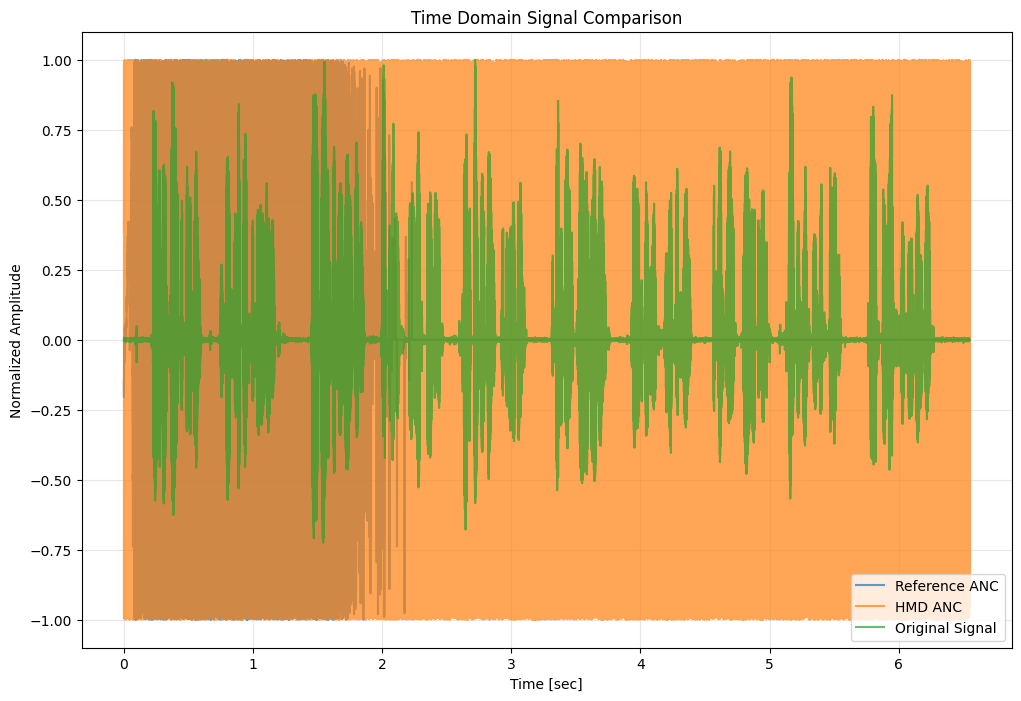


Performance Metrics:
Mean Square Normalized Error (Reference ANC): 6.9061
Mean Square Normalized Error (HMD ANC): 28.0897
Noise Reduction (Reference ANC): -8.39 dB
Noise Reduction (HMD ANC): -14.49 dB


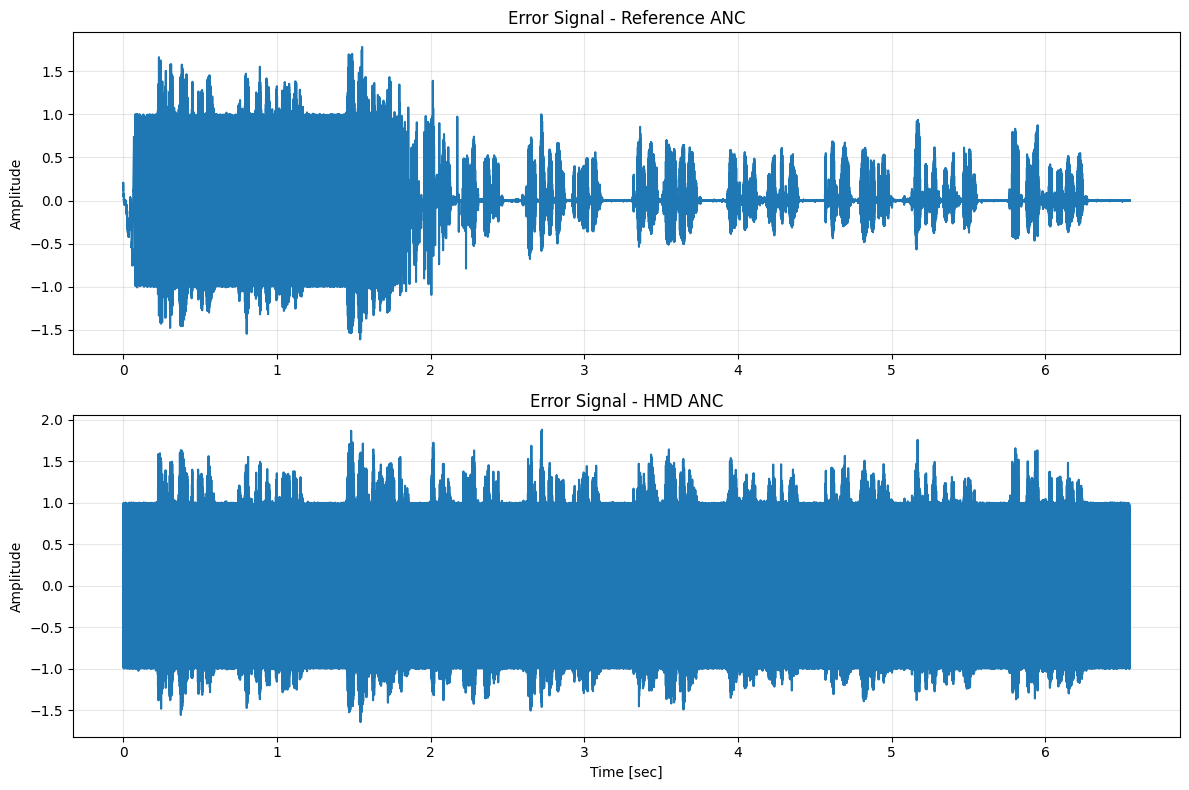

In [36]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np

def analyze_signals(ref_path, hmd_path, orig_path, sample_rate):
    """
    Analyze and compare different ANC outputs with proper normalization and error calculation
    """
    # Load signals and convert to float32 for consistent processing
    signals = []
    for path in [ref_path, hmd_path, orig_path]:
        rate, signal = wavfile.read(path)
        signal = signal.astype(np.float32)
        # Normalize to [-1, 1] range
        if np.max(np.abs(signal)) > 0:
            signal = signal / np.max(np.abs(signal))
        signals.append(signal)
    
    # Ensure all signals are of the same length
    min_len = min(len(s) for s in signals)
    signals = [s[:min_len] for s in signals]
    
    # Plot time domain comparison
    plt.figure(figsize=(12, 8))
    time = np.linspace(0, min_len / sample_rate, min_len)
    labels = ['Reference ANC', 'HMD ANC', 'Original Signal']
    
    for signal, label in zip(signals, labels):
        plt.plot(time, signal, label=label, alpha=0.7)
    
    plt.ylabel('Normalized Amplitude')
    plt.xlabel('Time [sec]')
    plt.title('Time Domain Signal Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Calculate proper MSNE (Mean Square Normalized Error)
    # MSNE = E[(e(n))^2] / E[(d(n))^2]
    # where e(n) is the error signal and d(n) is the desired (original) signal
    orig_power = np.mean(signals[2] ** 2)
    
    msne_ref = np.mean((signals[2] - signals[0]) ** 2) / (orig_power + 1e-10)
    msne_hmd = np.mean((signals[2] - signals[1]) ** 2) / (orig_power + 1e-10)
    
    # Calculate noise reduction in dB
    nr_ref = -10 * np.log10(msne_ref + 1e-10)
    nr_hmd = -10 * np.log10(msne_hmd + 1e-10)
    
    print("\nPerformance Metrics:")
    print(f"Mean Square Normalized Error (Reference ANC): {msne_ref:.4f}")
    print(f"Mean Square Normalized Error (HMD ANC): {msne_hmd:.4f}")
    print(f"Noise Reduction (Reference ANC): {nr_ref:.2f} dB")
    print(f"Noise Reduction (HMD ANC): {nr_hmd:.2f} dB")
    
    # Plot error signals
    plt.figure(figsize=(12, 8))
    error_ref = signals[2] - signals[0]
    error_hmd = signals[2] - signals[1]
    
    plt.subplot(2, 1, 1)
    plt.plot(time, error_ref)
    plt.title('Error Signal - Reference ANC')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 1, 2)
    plt.plot(time, error_hmd)
    plt.title('Error Signal - HMD ANC')
    plt.xlabel('Time [sec]')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Example usage
RATE = 48000  # Your sampling rate
signal_paths = {
    'ref': './sample_data/modified/output_ref_anc.wav',
    'hmd': './sample_data/modified/output_anti_noise.wav',
    'orig': './sample_data/modified/orig_signal.wav'
}

analyze_signals(signal_paths['ref'], signal_paths['hmd'], signal_paths['orig'], RATE)